# K-Nearest Neighbor - Wine dataset:

The Wine dataset is a popular dataset for classification included in the **sklearn** library. It contains several analyses of the content of three types of wines grown in the same region of Italy. The data set provides 178 samples, with 13 attributes each. **K-Nearest Neighbor** is a classification algorithm that labels a point based on the label of its k nearest neighbors.

First of all, we are going to load the data and save two columns (attributes): ***OD280/OD315 of diluted wines*** and ***Proline***. Then, we are going to use the DESCR command to gain insights about the data:

In [1]:
import numpy   as np
import matplotlib.pyplot as plt
import operator
from sklearn.datasets import load_wine

wine_data = load_wine()

X = wine_data.data
Y = wine_data.target

print(wine_data.DESCR)

a1 = X[:, 11]  # OD280/OD315 of diluted wines
a2 = X[:, 12]  # Proline

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

Then, we are going to design a method to nicely visualize the class to which a sample belongs by means of a scatter plot that confronts these two abovementioned attributes, in such a way that a **colour map** is superimposed to show us the **decision boundary** of the model:

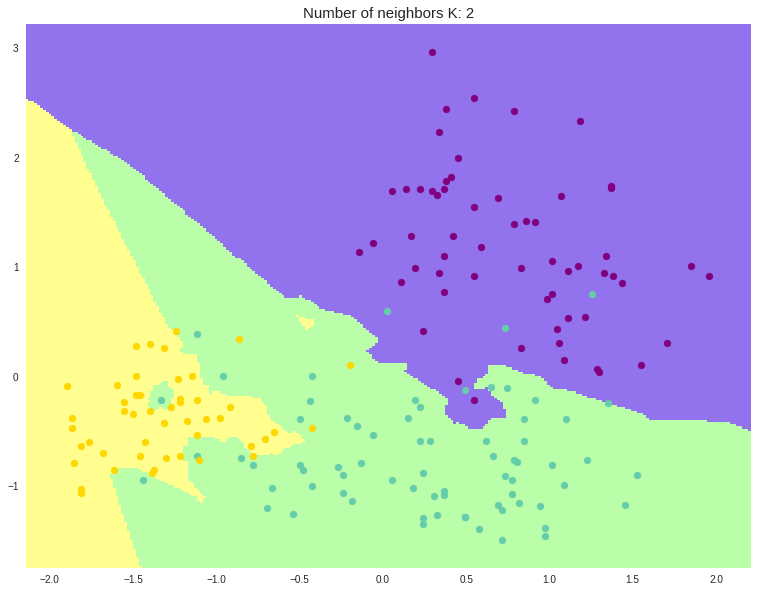

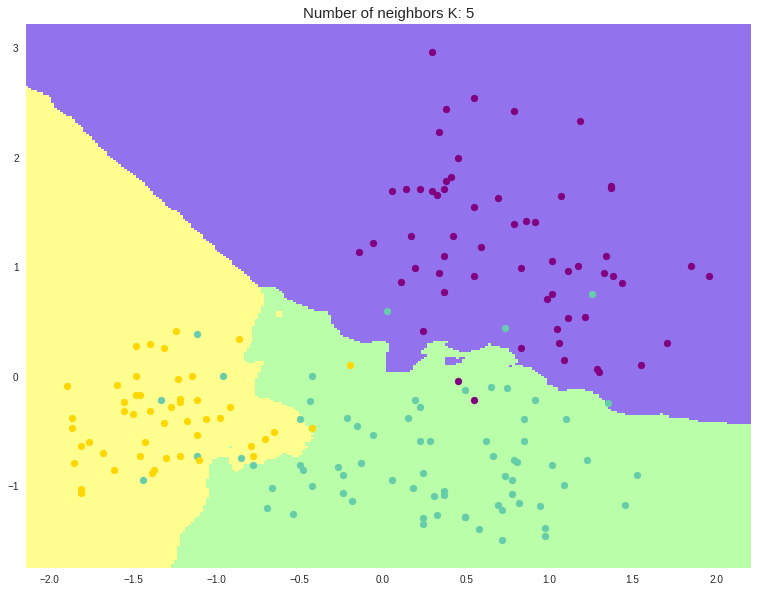

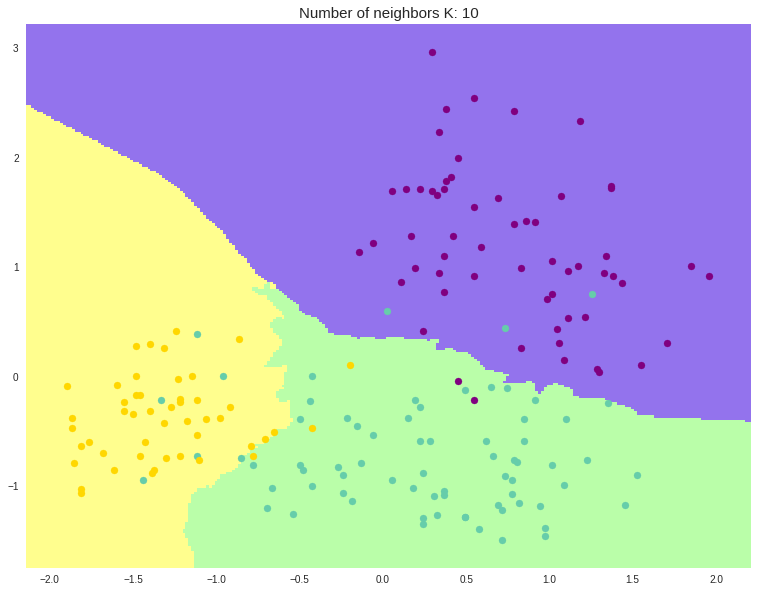

In [7]:
from matplotlib.colors import ListedColormap

dist = lambda m, n: np.sqrt(np.sum(np.power(m-n,2)))  # Euclidean distance between two points
  
def KNN(xgrid, ygrid, x1, x2, Y, k):  # Return each meshgrid point labelled

  res = np.zeros(shape=(len(xgrid), len(ygrid)))  # Empty meshgrid matrix

  for ix, x in enumerate(xgrid):    # Iterate through every coordinate of the meshgrid
    for iy, y in enumerate(ygrid):

      # Calculate euclidean distance between the current meshgrid coordinate and the existing labelled points
      distances = [dist(np.array([xgrid[ix, iy], ygrid[ix, iy]]),
                        np.array([x1[i], x2[i]])) for i in range(len(x1))]

      # argsort returns the indexes of the sorted array
      k_n_points = np.argsort(distances)[:k]  # Save the closest k indexes to each meshgrid point

      occurences = np.bincount(Y[k_n_points], minlength=3)  # Occurence of each class in these k-nearest-points
      res[ix, iy] = np.argmax(occurences)  # Fill the matrix with the most frequent class (0,1,2)

  return res

def visualize_kNN(x1, x2, Y, k):

  x1_n = (x1-np.mean(x1))/np.std(x1)  # Data standardization
  x2_n = (x2-np.mean(x2))/np.std(x2)

  steps = 250  # Meshgrid lenght
  
  # Create a coordinate matrix, i.e. meshgrid, of shape (steps, steps), return two axis
  xgrid, ygrid = np.meshgrid(np.linspace(x1_n.min()-0.25, x1_n.max()+0.25, steps), 
                             np.linspace(x2_n.min()-0.25, x2_n.max()+0.25, steps))

  mat012 = KNN(xgrid, ygrid, x1_n, x2_n, Y, k)  # label each meshgrid point

  colors = ListedColormap(['#9373ed','#bafea9','#fffe8e'])  # colors list
  
  plt.figure(figsize=(13,10))
  
  plt.pcolormesh(xgrid, ygrid, mat012, cmap=colors)  # color the Euclidean space

  plt.scatter(x1_n[Y == 0], x2_n[Y == 0], c="purple")  # color the available labelled samples
  plt.scatter(x1_n[Y == 1], x2_n[Y == 1], c="mediumaquamarine")
  plt.scatter(x1_n[Y == 2], x2_n[Y == 2], c="gold")
  
  plt.title("Number of neighbors K: " + str(k), size=15)
  plt.show()

visualize_kNN(a1, a2, Y, 2)  # take 2 neighbors for labeling
visualize_kNN(a1, a2, Y, 5)  # take 5 neighbors for labeling
visualize_kNN(a1, a2, Y, 10)  # take 10 neighbors for labeling

The figures above show the regions of Euclidean space which belong to a certain class based on the k-Nearest Neighbor criteria, for values of k equal to 2, 5 and 10. It should be noted that if we substantially increase the value of k, we may run the risk of overfitting the model to the data.

Now, let's determine which is the best **k** value to use to run the algorithm on all input variables of our Wine dataset. To do this, we use the ***KNeighborsClassifier*** function implemented by the ***sklearn*** library. For each k value, we will evaluate the model by dividing our training set by 10-Cross-validation: that is, we will train 10 times the model for each k value, using in each case a different fold for validation. With the 10 validation sets obtained for each k, we calculate and plot the average score achieved increasing k. Then, we can check if the optimal k value calculated with the 10 fold-Cross-validation corresponds to the optimal k value calculated by evaluating the model with the first data partition, performed at the start of the loop:

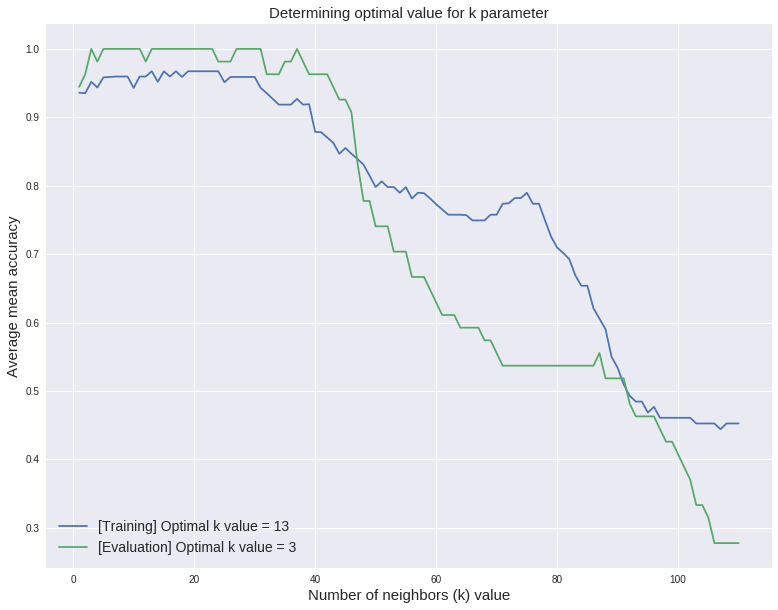

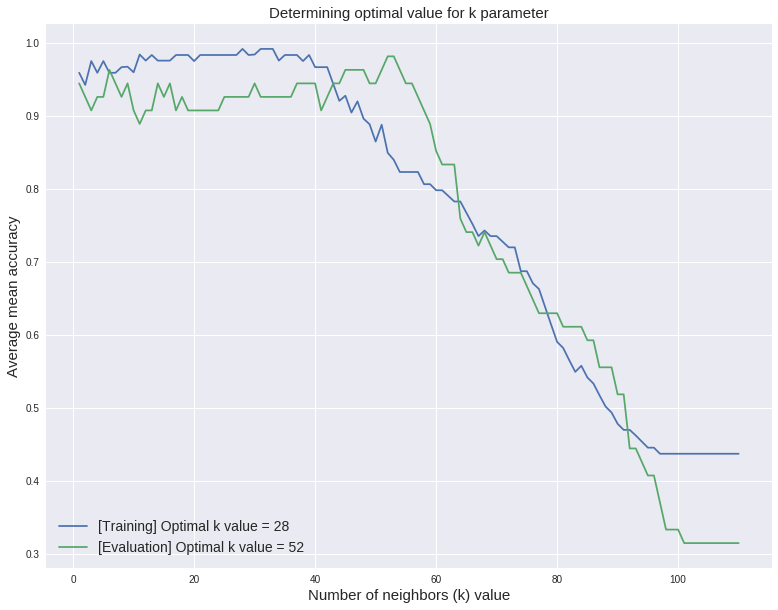

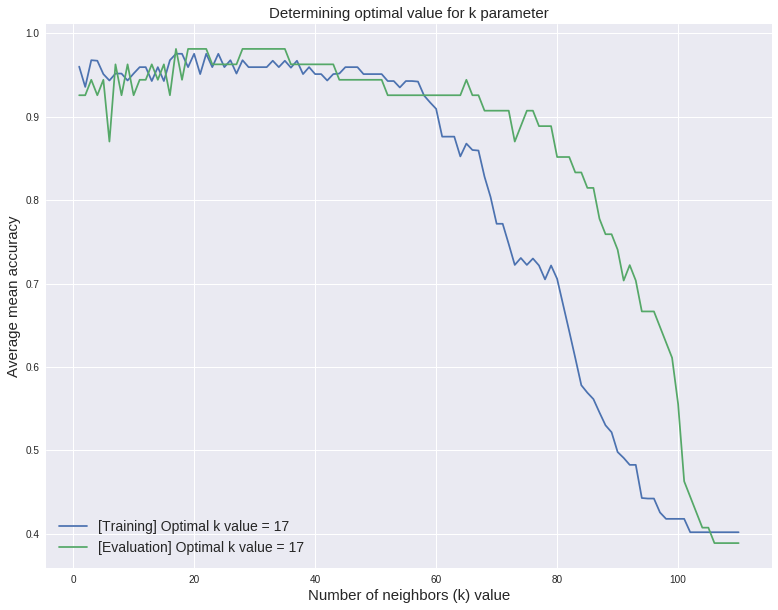

In [63]:
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier

for i in range(3):  # 3 different plots to check consistency of the calculation

  X_scaled = scale(X, with_mean=True, with_std=True)  # Standardize by subtraction of mean and division of std deviation
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.3)  # 70/30 % first data partition

  training_acc = []  # Training first with 10-fold cross validation

  lK = range(1, 111)  # k values from 1 to 110

  for k in lK:

    kfcv = KFold(n_splits=10)  # object that will return indexes of the 10 cross validation sets

    scores = []

    for id_train, id_test in kfcv.split(X_train):  # for each cross validation set

      tempX_train, tempX_val = X_train[id_train], X_train[id_test]
      tempY_train, tempY_val = y_train[id_train], y_train[id_test]

      knn_model = KNeighborsClassifier(n_neighbors=k).fit(tempX_train, tempY_train)  # train kNN classifier
      scores.append(knn_model.score(tempX_val, tempY_val))  # Evaluate, obtain mean accuracy

    training_acc.append(np.mean(scores))  # save avg of the mean accuracy

  plt.figure(figsize=(13,10))  # Plot the average accuracy value as the k value increases
  plt.plot(lK, training_acc, label='[Training] Optimal k value = {}'.format(np.argmax(training_acc)+1))

  
  # With the first data partition, we evaluate again to check consistency between the calculated k values

  evaluation_acc = []

  for k in lK:
    knn_model = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)  # train with the first partition
    evaluation_acc.append(knn_model.score(X_test, y_test))

  plt.plot(lK, evaluation_acc, label='[Evaluation] Optimal k value = {}'.format(np.argmax(evaluation_acc)+1))
  plt.title("Determining optimal value for k parameter", size=15)
  plt.xlabel("Number of neighbors (k) value", size=15)
  plt.ylabel("Average mean accuracy", size=15)
  plt.legend(loc='lower left', prop={'size': 14})  # Display the legend
  plt.show()


Choosing the optimal k value becomes a difficult task, since the model's performance is not so much affected by the k value itself, but by the data partition randomness, as it can be inferred by examining the 3 plots above, corresponding to different executions of the Training (k-fold) and Evaluation (original data partition). Perhaps the lack of data causes the calculation of the optimal k value to be stochastic.